# Hackathon

## Dependencies

Venv with 
- open3d
- numpy
- numpy-stl
- matplotlib

In [73]:
import numpy as np
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
import pickle
import open3d as o3d
from itertools import product
from stl import mesh

import trimesh

In [62]:
with open('test_image.pickle', 'rb') as f:
    data = pickle.load(f)
print(f"Input array shape: {data.shape}")

i = product(range(len(data)), range(len(data)))

points = list()
for element in list(i):
    x = element[0]
    y = element[1]
    z = np.average(data[element[0]][element[1]])
    points.append([x, y, z])

points = np.array(points)
print(f"NP array shape: {points.shape}")


Input array shape: (64, 64, 3)
NP array shape: (4096, 3)


In [64]:
points[0]

array([  0.,   0., 123.])

In [38]:
# looking at the first axis, each index contains three values that are all the same
for item in data[0]:
    assert item[0] == sum(item)/len(item)

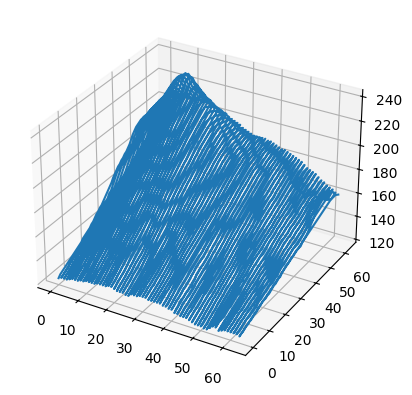

In [294]:
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D

v= points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(v[:,0],v[:,1],v[:,2])
plt.show()

In [274]:
def surface_to_edges(surface):
    """
    Takes 3d array describing the surface in cartesian coordinates
    returns list length 4, where each index is an array of indexes of the vertices describing the surface edge boundary

    [Edge1_listofvertices, Edge2_list_ofvertices, Edge3_list_ofvertices, Edge4_list_ofvertices]
    """

    # min and max values of the surface boundaries
    x_max, y_max, z_max = np.max(surface, axis=0)
    x_min, y_min, z_min = np.min(surface, axis=0)
    # print(f"{x_min=:.2f}, {x_max=:.2f}")
    # print(f"{y_min=:.2f}, {y_max=:.2f}")

    # list of the indexes of the vertices along each edge
    xmin_edge = [i for i, point in enumerate(surface) if point[0] == x_min]
    xmax_edge = [i for i, point in enumerate(surface) if point[0] == x_max]
    ymin_edge = [i for i, point in enumerate(surface) if point[1] == y_min]
    ymax_edge = [i for i, point in enumerate(surface) if point[1] == y_max]

    # array of list of vertice indexes for each edge 
    edges = [xmin_edge, xmax_edge, ymin_edge, ymax_edge]
    
    return edges

def gen_cube_bottom_faces(surface_vertices):
    """
    Calculates and adds the bottom vertices of the cube to the surface vertices 
    base_vertices: indexes of the bottom of cube vertices 
    return the two faces needed to make the bottom plane
    """

    x_max, y_max, z_max = np.max(surface_vertices, axis=0)
    x_min, y_min, z_min = np.min(surface_vertices, axis=0)
    # print(f"{z_min=:.2f}")
    # print(f"{z_max=:.2f}")

    base_ratio_to_surface_height = 0.1
    base_height = (z_max-z_min) * base_ratio_to_surface_height
    bottom_z = z_min - base_height

    # print(f"{base_height=:.2f}, {bottom_z=:.2f}")

    base_vertices = [[x_min, y_min, bottom_z],
                     [x_min, y_max, bottom_z],
                     [x_max, y_min, bottom_z],
                     [x_max, y_max, bottom_z]]
    
    surface_vertices = np.concatenate([surface_vertices, base_vertices])

    cube_bottom_faces_indexes = [ 
        [len(surface_vertices)-4, len(surface_vertices)-3, len(surface_vertices)-1],
        [len(surface_vertices)-3, len(surface_vertices)-2, len(surface_vertices)-1]
    ]
    return surface_vertices, cube_bottom_faces_indexes

def surfaceedge_to_faces(edge_virtices_indexes, base_i):
    """
    edge_virtex_indices: [V_i_0, ..., V_i_N] list of the indices of a given edge
    base_indices: [A, B] list with two elements which are the indices of the bottom corners associated with that edge
    
    Note: A should have share a coordinate with V_i_0 and B should share a coordinate with V_i_N

    return a list of faces 
    """ 
    # print(f"{base_i=}")
    faces = list()

    # first to n-1 edge
    for i in range(len(edge_virtices_indexes[:-1])):
        face = [edge_virtices_indexes[i], edge_virtices_indexes[i+1], base_i[0]+2]
        # print(f"{face=}")
        faces.append(face)

    # last edge
    face = [edge_virtices_indexes[-1], base_i[0]+2, base_i[1]]
    # print(f"{face=}")
    faces.append(face)

    return faces






In [291]:
def visualize_edges(verts):
    surface_edges = surface_to_edges(verts)

    x = [verts[edge_point][0] for edge_point in surface_edges]
    y = [verts[edge_point][1] for edge_point in surface_edges]
    z = [verts[edge_point][2] for edge_point in surface_edges]

    fig = plt.figure()
 
    # syntax for 3-D projection
    ax = plt.axes(projection ='3d')

    # x and y axis
    ax.scatter(x, y, z)
    plt.show()


def surface_to_height_mapped_cube(surface_mesh):

    # convert the mesh into vertices and faces
    surface_vertices = surface_mesh.vertices.view(np.ndarray)
    surface_faces = surface_mesh.faces.view(np.ndarray)
    # print(surface_vertices.shape)
    # print(surface_faces.shape)

    # print(f"{surface_faces=}")

    # find the boundary vertexes of the surface
    surface_edges = surface_to_edges(surface_vertices)

    # x = 
    # print([len(edge) for edge in surface_edges])
    # print(f"{surface_edges=}")

    # generating the bottom surface of the cube
    surfaces_vertices, cube_bottom_faces = gen_cube_bottom_faces(surface_vertices)
    # print(f"{surfaces_vertices=}")
    surface_faces = np.concatenate([surface_faces, cube_bottom_faces])
    # print(f"{surface_faces=}")

    # generate the faces that join the surface boundary and the bottom of the cube
    bottom_vertexes_indexes = [ [len(surface_vertices)-3, len(surface_vertices)-2],
                        [len(surface_vertices)-1, len(surface_vertices)-2],
                        [len(surface_vertices)-1, len(surface_vertices)-2],
                        [len(surface_vertices)-1, len(surface_vertices)-1]]
    
    bottom_vertexes_indexes = list([*bottom_vertexes_indexes[1:3], bottom_vertexes_indexes[0]])
    # print(f"{bottom_vertexes=}")

    boundary_faces = list()
    for edge, edge_bottom_vertex in zip(surface_edges, bottom_vertexes_indexes):
        new_faces = surfaceedge_to_faces(edge, edge_bottom_vertex)
        # print(new_faces)
        boundary_faces = list([*boundary_faces, *new_faces])
    # print(f"{boundary_faces=}")
    # print(np.array(boundary_faces).shape)
    surface_faces = np.append(surface_faces, boundary_faces)
    # print(f"{surface_faces=}")

    mesh = trimesh.Trimesh(vertices=surfaces_vertices, faces=surface_faces)
    return mesh

    
surface_mesh = trimesh.load("Surface_2DMesh.stl")

surface_vertices = surface_mesh.vertices.view(np.ndarray)
# visualize_edges(surface_vertices)



surface_mesh.show()
# updated_mesh = surface_to_height_mapped_cube(surface_mesh)
# updated_mesh.show()

In [65]:

# Define the 8 vertices of the cube
vertices = np.array([
    [-1, -1, -1], -> #1
    [+1, -1, -1], -> #2
    [+1, +1, -1],
    [-1, +1, -1],
    [-1, -1, +1],
    [+1, -1, +1],
    [+1, +1, +1],
    [-1, +1, +1]])

# Define the 12 triangles composing the cube
faces = np.array([\
    [0,3,1],
    [1,3,2],
    [0,4,7],
    [0,7,3],
    [4,5,6],
    [4,6,7],
    [5,1,2],
    [5,2,6],
    [2,3,6],
    [3,7,6],
    [0,1,5],
    [0,5,4]])

# Create the mesh
cube = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        cube.vectors[i][j] = vertices[f[j],:]

# Write the mesh to file "cube.stl"
cube.save('cube.stl')

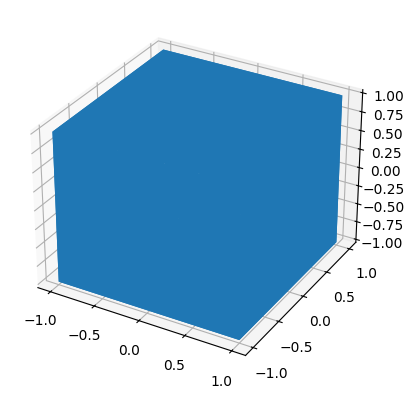

In [66]:
# Create a new plot
figure = pyplot.figure()
axes = figure.add_subplot(projection='3d')

# Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file('cube.stl')
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors))

# Auto scale to the mesh size
scale = your_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
pyplot.show()

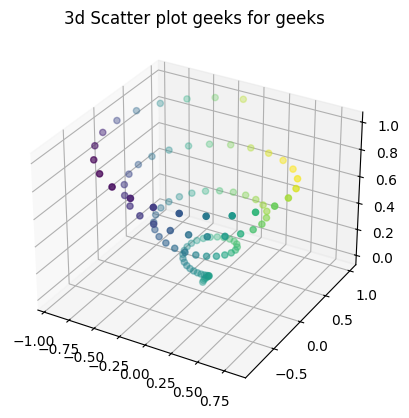

In [289]:
# importing mplot3d toolkits
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining axes
z = np.linspace(0, 1, 100)
x = z * np.sin(25 * z)
y = z * np.cos(25 * z)
c = x + y
ax.scatter(x, y, z, c = c)
 
# syntax for plotting
ax.set_title('3d Scatter plot geeks for geeks')
plt.show()